In [20]:
from user_ops import ft_pool
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math

import os
import sys
sys.path.append(os.path.join('..', '..', 'keras_frac'))
from fractional_maxpooling import FractionalPooling2D
import pickle

%matplotlib inline

In [2]:
class max_pool_net:
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same'))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same'))
        self.model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
    
    def train(self, batch_size, epochs, datagen=None, train_data=None, callbacks=None):
        if datagen is None and train_data is None:
            print('neither data or generator was passed')
        elif datagen is None and train_data is not None:
            print('training on array data, network type:', type(self).__name__)
            self.history = self.model.fit(x = train_data[0], y = train_data[1], validation_data=train_data[2:], batch_size=batch_size, epochs=epochs, callbacks=callbacks)
        else:
            print('training on datagen data, network type:', type(self).__name__)
            self.history = self.model.fit_generator(datagen, validation_data=train_data[2:], batch_size=batch_size, epochs=epochs, callbacks=callbacks)
        self.weights = self.model.get_weights()
    
    def restart_session(self):
        keras.backend.clear_session()
        
    def get_history(self):
        return self.history
    
    def get_weights(self):
        return self.weights
    
    def load_weights(self):
        self.model.load_weights(self.weights)

        
class frac_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        ratio = 1.35 # 1.33 blocks=3
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same'))
        self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same'))
        self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
    
    
class ft_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        strides=(math.sqrt(2), math.sqrt(2))
        pool_size=(math.sqrt(2), math.sqrt(2))
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same',))
        self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same'))
        self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
class avg_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        pool_size=2
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same',))
        self.model.add(keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2,2), padding='same'))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same'))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
            self.model.add(keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2,2), padding='same'))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same'))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())

In [3]:
EPOCHS = 200
BATCH_SIZE = 100
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
lr = keras.callbacks.ReduceLROnPlateau(patience=15, factor=.5, verbose=1)

In [4]:
ft_net = ft_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
ft_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[lr])
ft_net.restart_session()

avg_net = avg_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
avg_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[lr])
avg_net.restart_session()

max_net = max_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
max_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[lr])
max_net.restart_session()

frac_net = frac_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
frac_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[lr])
frac_net.restart_session()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (100, 32, 32, 2)          56        
_________________________________________________________________
lambda_1 (Lambda)            (100, 23, 23, 2)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (100, 23, 23, 2)          38        
_________________________________________________________________
lambda_2 (Lambda)            (100, 16, 16, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (100, 16, 16, 4)          76        
_________________________________________________________________
lambda_3 (Lambda)            (100, 11, 11, 4)          0         
________________________________________________

Epoch 40/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.4134 - accuracy: 0.5020 - val_loss: 1.4349 - val_accuracy: 0.4888
Epoch 41/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.4114 - accuracy: 0.5039 - val_loss: 1.4359 - val_accuracy: 0.4872
Epoch 42/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.4101 - accuracy: 0.5046 - val_loss: 1.4416 - val_accuracy: 0.4880
Epoch 43/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.4096 - accuracy: 0.5048 - val_loss: 1.4518 - val_accuracy: 0.4794
Epoch 44/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.4053 - accuracy: 0.5045 - val_loss: 1.4196 - val_accuracy: 0.4952
Epoch 45/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.4064 - accuracy: 0.5046 - val_loss: 1.4369 - val_accuracy: 0.4944
Epoch 46/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.4041 - ac

50000/50000 [==============================] - 16s 312us/step - loss: 1.3576 - accuracy: 0.5209 - val_loss: 1.3847 - val_accuracy: 0.5085
Epoch 95/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3552 - accuracy: 0.5204 - val_loss: 1.3931 - val_accuracy: 0.5029
Epoch 96/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3572 - accuracy: 0.5195 - val_loss: 1.3987 - val_accuracy: 0.5046
Epoch 97/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3558 - accuracy: 0.5198 - val_loss: 1.4006 - val_accuracy: 0.5003
Epoch 98/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3570 - accuracy: 0.5206 - val_loss: 1.3991 - val_accuracy: 0.5008
Epoch 99/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.3546 - accuracy: 0.5206 - val_loss: 1.3815 - val_accuracy: 0.5074
Epoch 100/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.3556 - accuracy: 0.52

50000/50000 [==============================] - 16s 312us/step - loss: 1.3313 - accuracy: 0.5280 - val_loss: 1.3815 - val_accuracy: 0.5094
Epoch 149/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.3310 - accuracy: 0.5273 - val_loss: 1.3669 - val_accuracy: 0.5127
Epoch 150/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.3309 - accuracy: 0.5287 - val_loss: 1.3864 - val_accuracy: 0.5049
Epoch 151/200
50000/50000 [==============================] - 16s 311us/step - loss: 1.3309 - accuracy: 0.5285 - val_loss: 1.3749 - val_accuracy: 0.5129
Epoch 152/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3316 - accuracy: 0.5273 - val_loss: 1.3797 - val_accuracy: 0.5128
Epoch 153/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3324 - accuracy: 0.5260 - val_loss: 1.3601 - val_accuracy: 0.5153
Epoch 154/200
50000/50000 [==============================] - 16s 312us/step - loss: 1.3315 - accuracy:

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 9s 172us/step - loss: 2.0560 - accuracy: 0.2511 - val_loss: 1.8614 - val_accuracy: 0.3336
Epoch 2/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.7434 - accuracy: 0.3786 - val_loss: 1.6659 - val_accuracy: 0.3998
Epoch 3/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.6292 - accuracy: 0.4192 - val_loss: 1.6005 - val_accuracy: 0.4217
Epoch 4/200
50000/50000 [==============================] - 9s 172us/step - loss: 1.5777 - accuracy: 0.4373 - val_loss: 1.5628 - val_accuracy: 0.4391
Epoch 5/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.5533 - accuracy: 0.4480 - val_loss: 1.5399 - val_accuracy: 0.4524
Epoch 6/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.5345 - accuracy: 0.4514 - val_loss: 1.5354 - val_accuracy: 0.4528
Epoch 7/200
50000/50000 [==============================]

50000/50000 [==============================] - 9s 171us/step - loss: 1.3919 - accuracy: 0.5020 - val_loss: 1.4261 - val_accuracy: 0.4900
Epoch 56/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3894 - accuracy: 0.5022 - val_loss: 1.4296 - val_accuracy: 0.4915
Epoch 57/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3909 - accuracy: 0.5021 - val_loss: 1.4201 - val_accuracy: 0.4928
Epoch 58/200
50000/50000 [==============================] - 9s 172us/step - loss: 1.3901 - accuracy: 0.5032 - val_loss: 1.4181 - val_accuracy: 0.4938
Epoch 59/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3888 - accuracy: 0.5031 - val_loss: 1.4211 - val_accuracy: 0.4964
Epoch 60/200
50000/50000 [==============================] - 9s 172us/step - loss: 1.3876 - accuracy: 0.5035 - val_loss: 1.4168 - val_accuracy: 0.4922
Epoch 61/200
50000/50000 [==============================] - 8s 170us/step - loss: 1.3873 - accuracy: 0.5051 - val

50000/50000 [==============================] - 9s 170us/step - loss: 1.3608 - accuracy: 0.5135 - val_loss: 1.3940 - val_accuracy: 0.5020
Epoch 110/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.3636 - accuracy: 0.5138 - val_loss: 1.3931 - val_accuracy: 0.5017
Epoch 111/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3617 - accuracy: 0.5128 - val_loss: 1.3863 - val_accuracy: 0.5038
Epoch 112/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.3636 - accuracy: 0.5139 - val_loss: 1.3967 - val_accuracy: 0.4982
Epoch 113/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3609 - accuracy: 0.5145 - val_loss: 1.3953 - val_accuracy: 0.5048
Epoch 114/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.3613 - accuracy: 0.5145 - val_loss: 1.4089 - val_accuracy: 0.4974
Epoch 115/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.3601 - accuracy: 0.5130

Epoch 163/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.3324 - accuracy: 0.5243 - val_loss: 1.3714 - val_accuracy: 0.5116
Epoch 164/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3327 - accuracy: 0.5239 - val_loss: 1.3764 - val_accuracy: 0.5114
Epoch 165/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3326 - accuracy: 0.5241 - val_loss: 1.3736 - val_accuracy: 0.5087
Epoch 166/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3326 - accuracy: 0.5252 - val_loss: 1.3808 - val_accuracy: 0.5088
Epoch 167/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3322 - accuracy: 0.5241 - val_loss: 1.3726 - val_accuracy: 0.5113
Epoch 168/200
50000/50000 [==============================] - 9s 170us/step - loss: 1.3309 - accuracy: 0.5252 - val_loss: 1.3751 - val_accuracy: 0.5079
Epoch 169/200
50000/50000 [==============================] - 9s 171us/step - loss: 1.3313 - ac

50000/50000 [==============================] - 13s 267us/step - loss: 1.4533 - accuracy: 0.4812 - val_loss: 1.4374 - val_accuracy: 0.4877
Epoch 8/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.4382 - accuracy: 0.4873 - val_loss: 1.4290 - val_accuracy: 0.4916
Epoch 9/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.4275 - accuracy: 0.4894 - val_loss: 1.4279 - val_accuracy: 0.4925
Epoch 10/200
50000/50000 [==============================] - 13s 267us/step - loss: 1.4183 - accuracy: 0.4948 - val_loss: 1.4296 - val_accuracy: 0.4864
Epoch 11/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.4098 - accuracy: 0.4997 - val_loss: 1.4145 - val_accuracy: 0.4955
Epoch 12/200
50000/50000 [==============================] - 13s 266us/step - loss: 1.4031 - accuracy: 0.5011 - val_loss: 1.4047 - val_accuracy: 0.5005
Epoch 13/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.3948 - accuracy: 0.5041 

50000/50000 [==============================] - 13s 268us/step - loss: 1.2865 - accuracy: 0.5448 - val_loss: 1.3083 - val_accuracy: 0.5362
Epoch 62/200
50000/50000 [==============================] - 13s 269us/step - loss: 1.2879 - accuracy: 0.5440 - val_loss: 1.3084 - val_accuracy: 0.5385
Epoch 63/200
50000/50000 [==============================] - 13s 269us/step - loss: 1.2861 - accuracy: 0.5454 - val_loss: 1.3235 - val_accuracy: 0.5336
Epoch 64/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2848 - accuracy: 0.5458 - val_loss: 1.2923 - val_accuracy: 0.5398
Epoch 65/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2830 - accuracy: 0.5456 - val_loss: 1.3028 - val_accuracy: 0.5365
Epoch 66/200
50000/50000 [==============================] - 13s 269us/step - loss: 1.2812 - accuracy: 0.5494 - val_loss: 1.3241 - val_accuracy: 0.5312
Epoch 67/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2794 - accuracy: 0.550

50000/50000 [==============================] - 13s 269us/step - loss: 1.2507 - accuracy: 0.5577 - val_loss: 1.2779 - val_accuracy: 0.5408
Epoch 116/200
50000/50000 [==============================] - 13s 269us/step - loss: 1.2476 - accuracy: 0.5574 - val_loss: 1.2669 - val_accuracy: 0.5519

Epoch 00116: ReduceLROnPlateau reducing learning rate to 0.5.
Epoch 117/200
50000/50000 [==============================] - 13s 267us/step - loss: 1.2306 - accuracy: 0.5644 - val_loss: 1.2685 - val_accuracy: 0.5485
Epoch 118/200
50000/50000 [==============================] - 14s 270us/step - loss: 1.2309 - accuracy: 0.5658 - val_loss: 1.2549 - val_accuracy: 0.5559
Epoch 119/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2309 - accuracy: 0.5654 - val_loss: 1.2610 - val_accuracy: 0.5548
Epoch 120/200
50000/50000 [==============================] - 13s 269us/step - loss: 1.2303 - accuracy: 0.5655 - val_loss: 1.2549 - val_accuracy: 0.5546
Epoch 121/200
50000/50000 [============

50000/50000 [==============================] - 13s 269us/step - loss: 1.2126 - accuracy: 0.5728 - val_loss: 1.2464 - val_accuracy: 0.5586
Epoch 169/200
50000/50000 [==============================] - 13s 270us/step - loss: 1.2123 - accuracy: 0.5706 - val_loss: 1.2493 - val_accuracy: 0.5584
Epoch 170/200
50000/50000 [==============================] - 13s 270us/step - loss: 1.2121 - accuracy: 0.5710 - val_loss: 1.2440 - val_accuracy: 0.5574
Epoch 171/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2122 - accuracy: 0.5716 - val_loss: 1.2486 - val_accuracy: 0.5560
Epoch 172/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2114 - accuracy: 0.5705 - val_loss: 1.2518 - val_accuracy: 0.5599
Epoch 173/200
50000/50000 [==============================] - 13s 268us/step - loss: 1.2119 - accuracy: 0.5706 - val_loss: 1.2467 - val_accuracy: 0.5575
Epoch 174/200
50000/50000 [==============================] - 13s 270us/step - loss: 1.2115 - accuracy:

50000/50000 [==============================] - 12s 233us/step - loss: 1.4842 - accuracy: 0.4743 - val_loss: 1.4844 - val_accuracy: 0.4717
Epoch 9/200
50000/50000 [==============================] - 12s 233us/step - loss: 1.4741 - accuracy: 0.4770 - val_loss: 1.4884 - val_accuracy: 0.4670
Epoch 10/200
50000/50000 [==============================] - 12s 232us/step - loss: 1.4653 - accuracy: 0.4806 - val_loss: 1.4703 - val_accuracy: 0.4735
Epoch 11/200
50000/50000 [==============================] - 12s 233us/step - loss: 1.4565 - accuracy: 0.4840 - val_loss: 1.4784 - val_accuracy: 0.4719
Epoch 12/200
50000/50000 [==============================] - 12s 233us/step - loss: 1.4504 - accuracy: 0.4865 - val_loss: 1.4766 - val_accuracy: 0.4733
Epoch 13/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.4430 - accuracy: 0.4882 - val_loss: 1.4628 - val_accuracy: 0.4812
Epoch 14/200
50000/50000 [==============================] - 12s 233us/step - loss: 1.4372 - accuracy: 0.4905

50000/50000 [==============================] - 12s 235us/step - loss: 1.3308 - accuracy: 0.5324 - val_loss: 1.3728 - val_accuracy: 0.5078
Epoch 63/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.3304 - accuracy: 0.5327 - val_loss: 1.3806 - val_accuracy: 0.5108
Epoch 64/200
50000/50000 [==============================] - 12s 233us/step - loss: 1.3300 - accuracy: 0.5318 - val_loss: 1.3740 - val_accuracy: 0.5124
Epoch 65/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.3279 - accuracy: 0.5331 - val_loss: 1.3688 - val_accuracy: 0.5127
Epoch 66/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.3275 - accuracy: 0.5344 - val_loss: 1.3790 - val_accuracy: 0.5109
Epoch 67/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.3267 - accuracy: 0.5328 - val_loss: 1.3638 - val_accuracy: 0.5134
Epoch 68/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.3266 - accuracy: 0.533

50000/50000 [==============================] - 12s 233us/step - loss: 1.2953 - accuracy: 0.5462 - val_loss: 1.3458 - val_accuracy: 0.5241
Epoch 117/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2972 - accuracy: 0.5464 - val_loss: 1.3480 - val_accuracy: 0.5234
Epoch 118/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2961 - accuracy: 0.5465 - val_loss: 1.3578 - val_accuracy: 0.5205
Epoch 119/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.2965 - accuracy: 0.5450 - val_loss: 1.3593 - val_accuracy: 0.5153
Epoch 120/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2934 - accuracy: 0.5466 - val_loss: 1.3356 - val_accuracy: 0.5253
Epoch 121/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2925 - accuracy: 0.5467 - val_loss: 1.3313 - val_accuracy: 0.5303
Epoch 122/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2932 - accuracy:

50000/50000 [==============================] - 12s 234us/step - loss: 1.2594 - accuracy: 0.5586 - val_loss: 1.3128 - val_accuracy: 0.5371
Epoch 170/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.2583 - accuracy: 0.5596 - val_loss: 1.3217 - val_accuracy: 0.5297
Epoch 171/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.2591 - accuracy: 0.5585 - val_loss: 1.3140 - val_accuracy: 0.5313
Epoch 172/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.2576 - accuracy: 0.5591 - val_loss: 1.3168 - val_accuracy: 0.5320
Epoch 173/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2580 - accuracy: 0.5601 - val_loss: 1.3270 - val_accuracy: 0.5300
Epoch 174/200
50000/50000 [==============================] - 12s 235us/step - loss: 1.2578 - accuracy: 0.5607 - val_loss: 1.3151 - val_accuracy: 0.5335
Epoch 175/200
50000/50000 [==============================] - 12s 234us/step - loss: 1.2563 - accuracy:

In [5]:
# baseline best 2x max pool = 53.19%

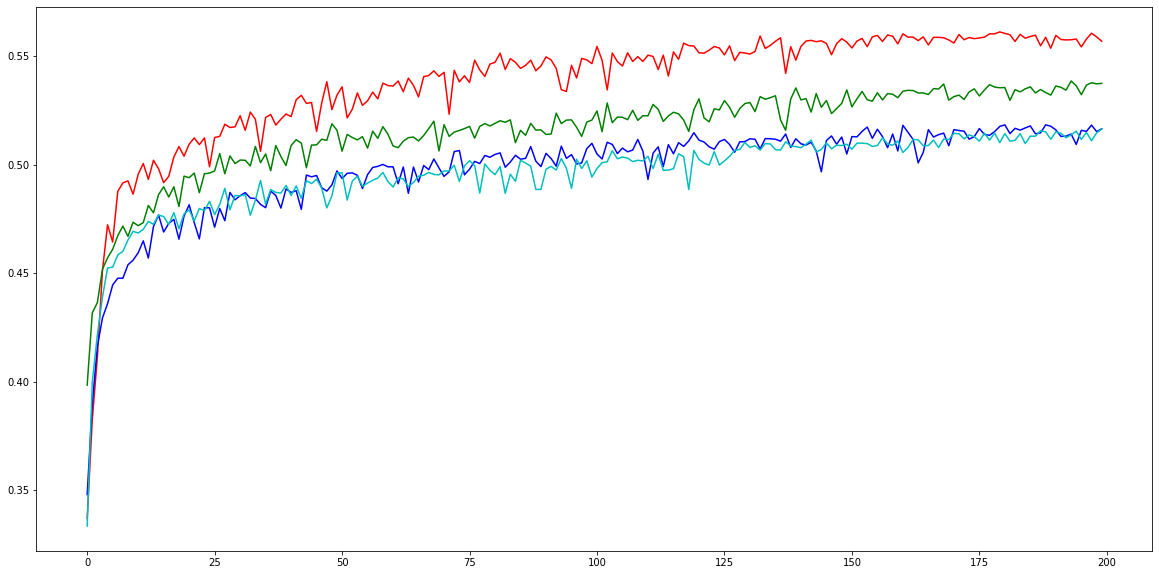

In [6]:
# petruv pristup - nasobeno pouze vahou
fig = plt.figure(figsize=(20,10))
plt.plot(max_net.get_history().history['val_accuracy'], 'r')
plt.plot(frac_net.get_history().history['val_accuracy'], 'g')
plt.plot(ft_net.get_history().history['val_accuracy'], 'b')
plt.plot(avg_net.get_history().history['val_accuracy'], 'c')
plt.show()

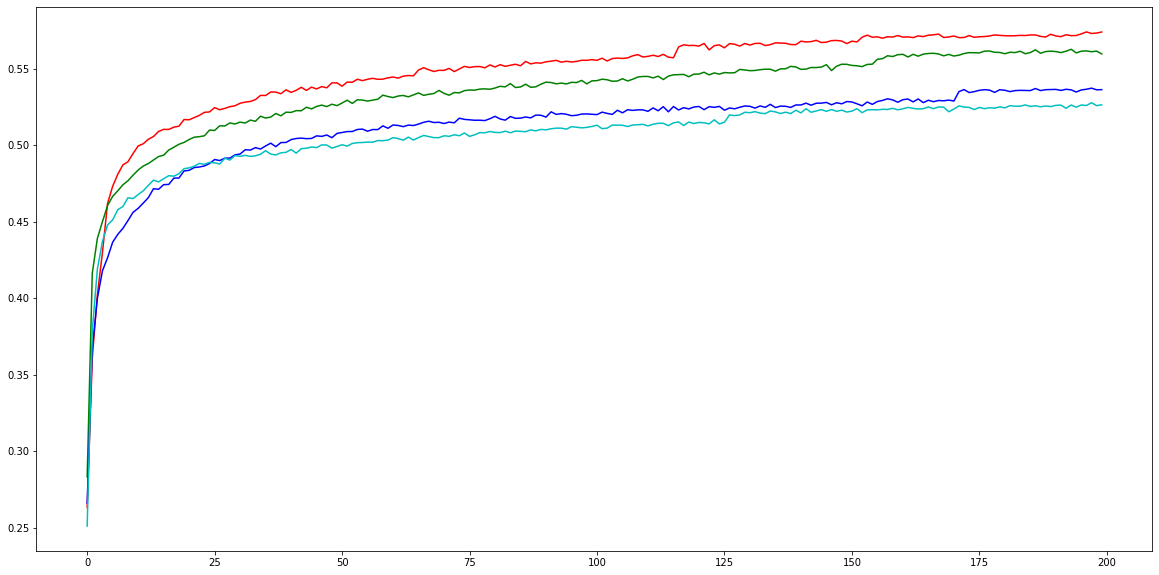

In [8]:
# petruv pristup - nasobeno pouze vahou
fig = plt.figure(figsize=(20,10))
plt.plot(max_net.get_history().history['accuracy'], 'r')
plt.plot(frac_net.get_history().history['accuracy'], 'g')
plt.plot(ft_net.get_history().history['accuracy'], 'b')
plt.plot(avg_net.get_history().history['accuracy'], 'c')
plt.show()

In [26]:
'''
with open('avg_net_history', 'wb') as f:
    del avg_net.get_history().history['lr']
    pickle.dump(avg_net.get_history().history, f)
'''